In [19]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

In [20]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("socialmediaie/TRAC2020_ENG_A_bert-base-uncased")
# model = AutoModelForSequenceClassification.from_pretrained(
#     "socialmediaie/TRAC2020_ENG_A_bert-base-uncased", 
#     num_labels=1, 
#     ignore_mismatched_sizes=True
# ).to("cuda")

model = AutoModelForSequenceClassification.from_pretrained(
    './hf_israel/run1/checkpoint-4500'
).to("cuda")

In [21]:

with open('twitter_before_tfidf.pkl', 'rb') as f:
    twitter_before_tfidf = pickle.load(f)
with open('reddit_after_tfidf.pkl', 'rb') as f:
    reddit_after_tfidf = pickle.load(f)
    
with open('twitter_before_cleaned.pkl', 'rb') as f:
    twitter_before = pickle.load(f)
with open('reddit_after_cleaned.pkl', 'rb') as f:
    reddit_after = pickle.load(f)


with open('twitter_before_doc_toxicity_scores.pkl', 'rb') as f:
    twitter_before_doc_toxicity_scores = pickle.load(f)
with open('reddit_after_doc_toxicity_scores.pkl', 'rb') as f:
    reddit_after_doc_toxicity_scores = pickle.load(f)

In [6]:
print(twitter_before.shape)
print(reddit_after.shape)

(24251, 5)
(436718, 3)


In [22]:
x_train = twitter_before['cleaned_text'].tolist()
y_train = twitter_before_doc_toxicity_scores
x_test = reddit_after['cleaned_text'].tolist()
y_test = reddit_after_doc_toxicity_scores

In [23]:
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader

max_length = model.config.max_position_embeddings


# Using Dataset
def batch_tokenize(texts, tokenizer, batch_size=32, max_length=None):
    # Tokenize all texts at once (adjust if memory constraints are an issue)
    encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=max_length, return_tensors="pt")
    return encodings

train_encodings = batch_tokenize(x_train, tokenizer, max_length=max_length)
test_encodings = batch_tokenize(x_test, tokenizer, max_length=max_length)


# with open('train_encodings.pkl', 'rb') as f:
#     train_encodings = pickle.load(f)
# with open('test_encodings.pkl', 'rb') as f:
#     test_encodings = pickle.load(f)

In [24]:
''''
Custom dataset was created using a PyTorch Dataset for handling theBERT input encodings and correspondings labels. Data is now tensors for preprocessing PyTorch. 

The getitem function converts each data point into a dictionary (expected by Hugging Face), which includes converting all parts of the encodings into tensors and reshaping labels as float tensors.

'''


class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor([self.labels[idx]], dtype=torch.float)  # Ensure labels are correctly shaped
        return item

    def __len__(self):
        return len(self.labels)

# # Create dataset
train_dataset = CustomDataset(train_encodings, y_train)
test_dataset = CustomDataset(test_encodings, y_test)

#create for batching the data, which is necessary for training the model efficiently. 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)



In [15]:
#https://towardsdatascience.com/linear-regression-with-hugging-face-3883fe729324
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error

num_epochs=3

#compute the metrics for regression
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}


# Specifiy the arguments for the trainer  
training_args = TrainingArguments(
    fp16=True,
    output_dir ='./israelGaza/run1',          
    num_train_epochs = num_epochs,     
    per_device_train_batch_size = 16,   
    per_device_eval_batch_size = 16,   
    # weight_decay = 0.01,               
    # learning_rate = 2e-5,
    logging_dir = './logs/run1',            
    save_total_limit = 10,
    #load_best_model_at_end = True,     
    # metric_for_best_model = 'mse',    
    evaluation_strategy = "epoch",
    # save_strategy = "epoch",
) 
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)


# Call the Trainer
trainer = Trainer(
    model = model,                         
    args = training_args,                  
    train_dataset = train_dataset,         
    eval_dataset = test_dataset, 
    compute_metrics = compute_metrics_for_regression,     
)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/home/mrtcloud-8/miniconda3/envs/hf_38_john/lib/python3.8/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgra

In [29]:
# Train the model
trainer.train()

KeyboardInterrupt: 

In [16]:
trainer.evaluate()

/tmp/ipykernel_518106/2487367678.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.014447144232690334,
 'eval_mse': 0.014447144232690334,
 'eval_rmse': 0.12019627541303635,
 'eval_mae': 0.049363598227500916,
 'eval_r2': 0.2909563904748538,
 'eval_smape': 139.35928448106102,
 'eval_runtime': 1892.3493,
 'eval_samples_per_second': 230.781,
 'eval_steps_per_second': 14.424}

/tmp/ipykernel_518106/2487367678.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


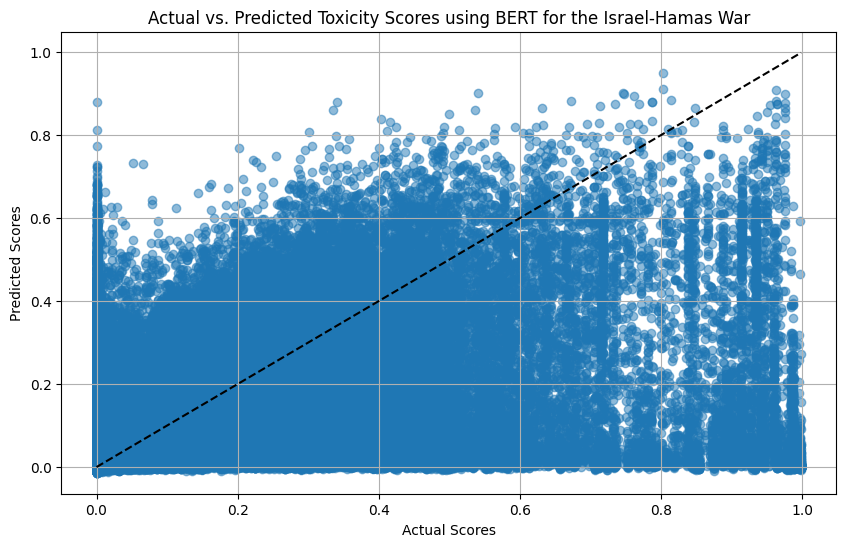

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

#get predicted scores with proper shape
predictions = trainer.predict(test_dataset)
predicted_scores = predictions.predictions
predicted_scores = predicted_scores.squeeze() 

#get actual scores and ensure proper shape
actual_scores = np.array(y_test).flatten()

#create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_scores, predicted_scores, alpha=0.5)
plt.title('Actual vs. Predicted Toxicity Scores using BERT for the Israel-Hamas War')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.grid(True)
plt.plot([min(actual_scores), max(actual_scores)], [min(actual_scores), max(actual_scores)], 'k--')  # Diagonal line
plt.show()


/tmp/ipykernel_363183/4154247393.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('winter')


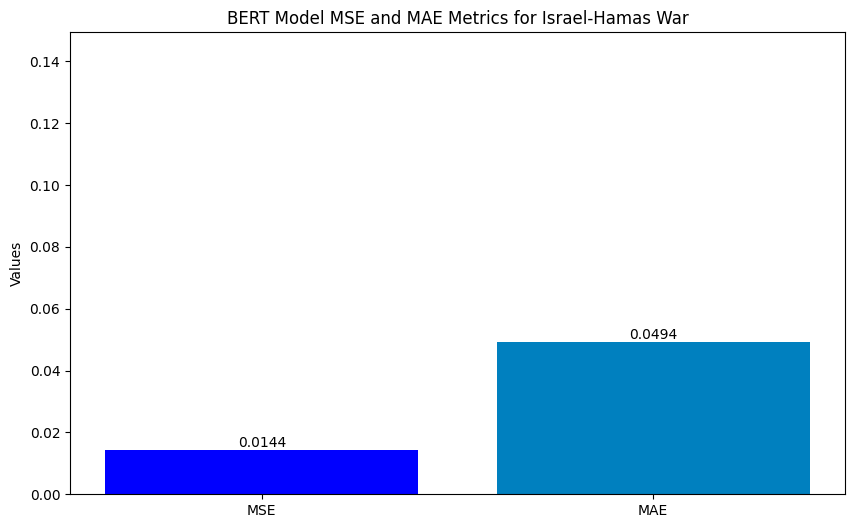

In [27]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
cmap = get_cmap('winter')
colors = cmap(np.linspace(0, 1, 3))
#extract results
results = {
    'eval_mse': 0.014447144232690334,
    'eval_mae': 0.049363598227500916,
}
#plot
metrics = ['MSE', 'MAE']
values = [results['eval_mse'], results['eval_mae']]

# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(metrics, values, color=[colors[0], colors[1], colors[2]])  

# Add titles and labels
plt.title('BERT Model MSE and MAE Metrics for Israel-Hamas War')
plt.ylabel('Values')
plt.ylim(0, max(values) + 0.1)  # Set y-limits to make R2 value clear

# Adding data labels
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar (value of the metric)
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4),  # Position the text in the middle of the bar
             verticalalignment='bottom' if yval < 0 else 'bottom',  # Adjust alignment for negative values
             ha='center')  # Horizontal alignment is center


# Display the plot
plt.show()